In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
import statsmodels.tsa.stattools
from arch.unitroot import ADF
import statsmodels.api as sm
%matplotlib inline

In [2]:
#importing data and calculating daily differences
di = "/users/Edith/Python/Data/"
data = pd.read_excel(di+'CMT-all.xlsx', index_col = 0)

sample_1=data.ix['2013-01-01':'2014-12-31',['3M','2Y','5Y','7Y','10Y','30Y']]
sample_2=data.ix['2015-01-01':'2016-12-31',['3M','2Y','5Y','7Y','10Y','30Y']]

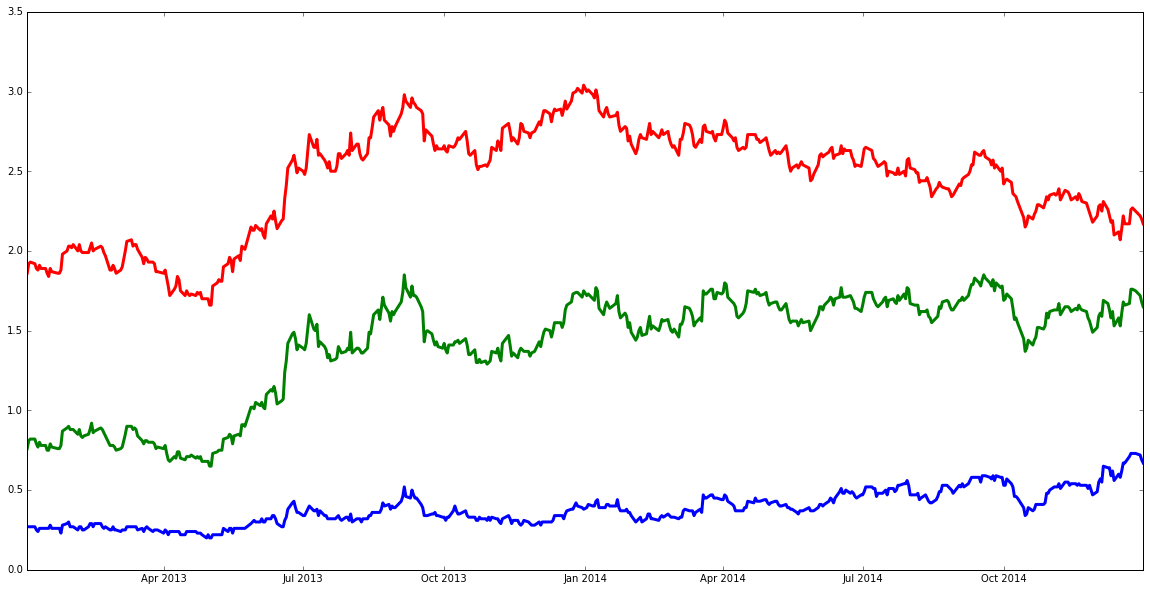

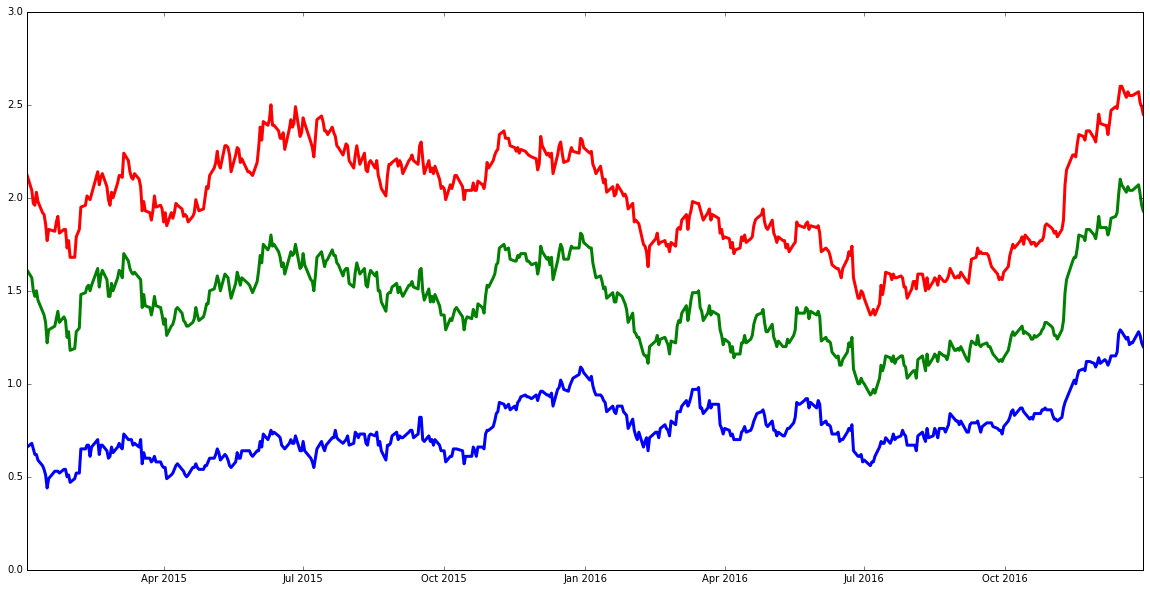

In [215]:
legs = ['2Y', '10Y']
belly = '5Y'
flylist = [legs[0],belly, legs[1]]

sample_1_fly=data.ix['2013-01-01':'2014-12-31',flylist]
sample_2_fly=data.ix['2015-01-01':'2016-12-31',flylist]

sample_1_rtns= sample_1.diff()
sample_2_rtns= sample_2.diff()
sample_q_rtns= sample_2.diff()

plt.figure(figsize=(20,10))
plt.plot(sample_1_fly,linewidth=3)
plt.show()
plt.figure(figsize=(20,10))
plt.plot(sample_2_fly,linewidth=3)
plt.show()

In [4]:
def PCA_simple(data_set):
    c = data_set.cov()
    val, vec = np.linalg.eig(c)
    return pd.DataFrame(vec)

In [57]:
def Factor_Neutral_Weights(df, legs_index, target_index):
    n = len(legs_index)
    x = df.ix[legs_index,range(n)]
    y = df.ix[target_index,range(n)]
    x = x.as_matrix()
    y = y.as_matrix()
    z=np.linalg.inv(x)
    w = np.matmul(y,z)
    if sum(w) < 0:
        w = [ww*(-1) for ww in w]
    return w
    

In [197]:
def ols_weights(df, x_index, y_index):
    x = df[x_index].as_matrix()
    y = df[y_index].as_matrix()
    x_I = sm.add_constant(x)
    l = sm.OLS(y,x_I).fit()
    n = len(x_index)
    return l.params[1:(n+1)]

In [191]:
v = PCA_simple(sample_1)
w_pca_lev = Factor_Neutral_Weights(v,[1,4],2) 
print (w_pca_lev)
v = PCA_simple(sample_1_rtns)
w_pca_ret = Factor_Neutral_Weights(v,[1,4],2) 
print (w_pca_ret)

[ 2.03850473  0.60292276]
[ 1.13693977  0.54779512]


In [201]:
w_ols = ols_weights(sample_1_fly,legs,[belly])
print (w_ols)

[ 1.83432697  0.62525271]


In [216]:
def CCA_Chou_Ng(data_set):
    
    df_lag = data_set.shift(1).dropna()
    df = data_set.drop(data_set.index[0]).dropna()
    n = len(data_set.columns)
    
    #X(t) ~ M_! + X(t-1)
    X = df_lag.as_matrix()
    X_I = sm.add_constant(X)
    Y = df.as_matrix()
    l1 = sm.OLS(Y,X_I).fit()
    B=l1.params[1:(n+1)]
    
    #X(t-1) ~ M_2 + X(t)
    Y_I = sm.add_constant(X)
    l2 = sm.OLS(X,Y_I).fit()
    A=l2.params[1:(n+1)]
    C = np.dot(A,B)
    eig_val, eig_vec = np.linalg.eig(C)
    return eig_val, eig_vec, C

In [218]:
df = sample_1_fly
n = len(df.columns)
val, vec, C = CCA_Chou_Ng(df)
vec = pd.DataFrame(vec)
vec = vec.rename(columns=lambda x: n-x-1, inplace=False)
print (vec)
w = vec[2].values
w_cca_cn = [-w[0]/w[1],-w[2]/w[1]]
print (w_cca_cn)

          2         1         0
0  0.859852  0.282033 -0.576731
1 -0.431059 -0.765590  0.740764
2  0.273574  0.578212 -0.344456
[1.9947434220096745, 0.6346567849044632]


In [94]:
def fly(df,legs,w):
    return df[legs[0]]*w[0]-df[legs[1]]+df[legs[2]]*w[1]

In [199]:
w = {'Equal':[1,1],
     'PCA Diffs': w_pca_ret, 
     'PCA Level': w_pca_lev, 
     'OLS Level': w_ols,
     'Coint': w_cca_cn }

legs = flylist
for k in w.keys():
    print ('Weights: ',w[k])
    fly_1 = fly(sample_1_fly,legs,w[k]) 
    fly_2 = fly(sample_2_fly,legs,w[k]) 

    adfuller_fly_1 = ADF(fly_1,lags = 1)
    print('ADF Test Summary, Sample 1: '+k, adfuller_fly_1)
    adfuller_fly_2 = ADF(fly_2, lags = 1)
    print('\n \n ADF Test Summary, Sample 2: '+k, adfuller_fly_2)



('Weights: ', array([ 1.83432697,  0.62525271]))
('ADF Test Summary, Sample 1: OLS Level', <class 'arch.unitroot.unitroot.ADF'>
"""
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.759
P-value                         0.003
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""")
('\n \n ADF Test Summary, Sample 2: OLS Level', <class 'arch.unitroot.unitroot.ADF'>
"""
   Augmented Dickey-Fuller Results   
Test Statistic                 -0.961
P-value                         0.767
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""")
('Weights: ', array([ 2.0385047